In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-07-25 19:11:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-07-25 19:11:19 (126 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [3]:
import os

for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Tez Dosyaları/birlesik veriseti 2 classli"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/content/drive/MyDrive/Tez Dosyaları/birlesik veriseti 2 classli'.
There are 2 directories and 0 images in '/content/drive/MyDrive/Tez Dosyaları/birlesik veriseti 2 classli/Train'.
There are 0 directories and 840 images in '/content/drive/MyDrive/Tez Dosyaları/birlesik veriseti 2 classli/Train/Malignant'.
There are 0 directories and 575 images in '/content/drive/MyDrive/Tez Dosyaları/birlesik veriseti 2 classli/Train/Benign'.
There are 2 directories and 0 images in '/content/drive/MyDrive/Tez Dosyaları/birlesik veriseti 2 classli/Test'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Tez Dosyaları/birlesik veriseti 2 classli/Test/Benign'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Tez Dosyaları/birlesik veriseti 2 classli/Test/Malignant'.


In [4]:
train_dir = "/content/drive/MyDrive/Tez Dosyaları/birlesik veriseti 2 classli/Train"
test_dir = "/content/drive/MyDrive/Tez Dosyaları/birlesik veriseti 2 classli/Test"

In [5]:
import tensorflow as tf
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_data= tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                          label_mode="binary",
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                          label_mode="binary",
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE)

Found 1415 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [6]:
train_data.class_names

['Benign', 'Malignant']

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import random
import math
import csv
import cv2
import os

In [22]:
# 1.  create base model with tf.keras.applications
base_model = tf.keras.applications.DenseNet121(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. if using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. create the output activation layer
outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(x)
model_0 = tf.keras.Model(inputs, outputs)

# 8. compile the model
model_0.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 9. fit the model
history_0 = model_0.fit(train_data,
                        epochs=40,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                              experiment_name="10_percent_feature_extraction")])


29084464/29084464 [==============================] - 2s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1024)
Shape after GlobalAveragePooling2D: (None, 1024)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240725-193607
Epoch 1/40
45/45 [==============================] - 26s 336ms/step - loss: 0.7934 - accuracy: 0.5223 - val_loss: 0.6796 - val_accuracy: 0.5850
Epoch 2/40
45/45 [==============================] - 10s 191ms/step - loss: 0.6900 - accuracy: 0.6071 - val_loss: 0.6569 - val_accuracy: 0.6550
Epoch 3/40
45/45 [==============================] - 10s 186ms/step - loss: 0.6849 - accuracy: 0.6049 - val_loss: 0.6549 - val_accuracy: 0.5850
Epoch 4/40
45/45 [==============================] - 10s 186ms/step - loss: 0.6732 - accuracy: 0.6269 - val_loss: 0.6375 - val_accuracy: 0.6650
Epoch 5/40
45/45 [==============================] - 10s 193ms/step - loss: 0.6355 - accuracy: 0.6537 - val_loss: 0.6595 - val_accuracy: 0.6950
Epoch 6/

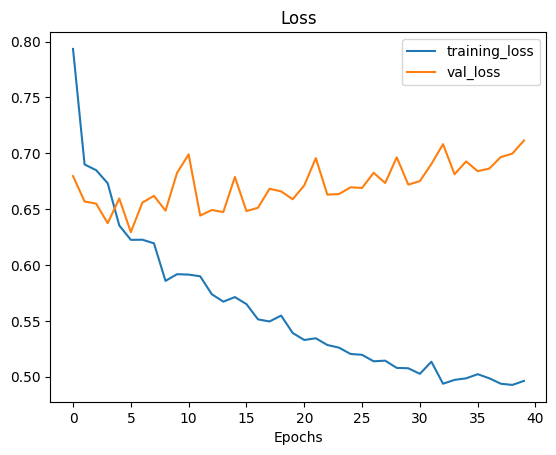

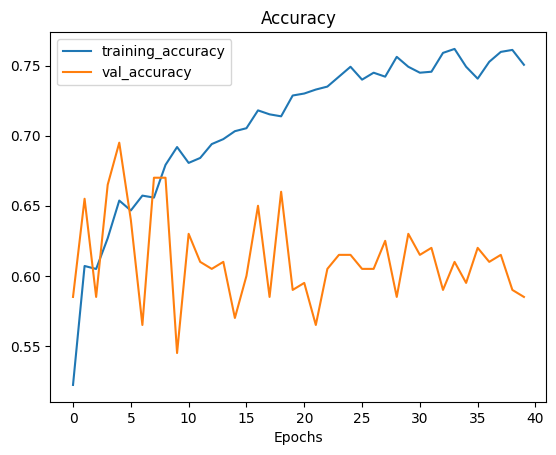

In [23]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow History object.

    Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  #Plot loss

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(history_0)

In [24]:

results_feature_extraction = model_0.evaluate(test_data)
results_feature_extraction

7/7 [==============================] - 2s 80ms/step - loss: 0.7114 - accuracy: 0.5850


[0.7114375233650208, 0.5849999785423279]

In [25]:
# Get the predicted probabilities for the test set
y_pred_probs = model_0.predict(test_data)

# Convert probabilities to binary predictions (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int)

# Get the true labels for the test set
y_true = np.concatenate([y for x, y in test_data], axis=0)

# Calculate precision
from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred)
print("Precision:", precision)

7/7 [==============================] - 3s 96ms/step
Precision: 0.536


In [26]:

from sklearn.metrics import recall_score

# Calculate recall
recall = recall_score(y_true, y_pred)
print("Recall:", recall)


Recall: 0.67


In [27]:
from sklearn.metrics import f1_score
# Calculate F1-score
f1 = f1_score(y_true, y_pred)
print("F1-score:", f1)


F1-score: 0.5955555555555556


In [28]:
# Eğitim doğruluğunu elde etmek için history_0 nesnesini kullanın
train_accuracy = history_0.history['accuracy']

# Son epoch'un eğitim doğruluğunu yazdırın
print("Eğitim doğruluğu:", train_accuracy[-1])

Eğitim doğruluğu: 0.7505300641059875
